Image Filters/Kernel

Computer Vision
- using computer programs to process image data

Image Kernal
- a small matrix applied to an entire image
- certain popular filters are well known, for example the blur filter

- Filters allow us to transform an image
- Essentially multiply by filter weights, and then sum the result
- stirde across the image, can edit our stride, has to be at least one pixel over at a time
    - you stride (drag/slide the filter matrix across the image matrix)

Filters can do other things such as identify features such as eyebrows, this would be helpful in facial recognition

setosa.io/ev/image-kernels/ interactive to see how this works


In the context of CNNs these filters are referred to as convolution kernels

The process of passing them over an image is known as convolution

During convolution we would lose borders, you can pad the image with more values such as 0's all the way around

Convolutional Layers
- created when we apply multiple image filters to the input images
- layer will then be trained to figure out the best filter weight values
- reduces parameters by focusing on local connectivity
- not all neurons are fully connected
- neurons are only connected to a subset of local neurons in the next layer (these end up being the filters)

When dealing with color you will have width and height and three color channels. If you grab just one of those color channels it will look like gray scale because it just represents the intensity of that color scale (red, green, blue). When you combine them you get the colored image. Computer doesnt know that a channel is red it just knows that there are three intensity channels.

You will get a 3 dimensional filter to deal with color images, and can still create multiple layers

Often convolutional layers are fed into another convolutional layer
- network can discover patterns within patterns

Pooling Layers
- pooling layers accept convolutional layers as input
- this can decrease parameters

Use max pooling 
- choose window size (ex.2 2x2) and stride (ex. 2)
- take the max value of the subset matrix in the window
- loose some of the information but it maintains the general information

Can also use average pooling

Another common technique is the dropout layer
- a form of regularization to help prevent overfitting
- during training, units are randomly dropped along with their connections
- helps prevent units from co-adapting too much

There are other architectures as well
- AlexNet
- many more too


Can have all types fo architectures
- input, conv, conv, conv, pool
- input, conv, pool, conv, pool

Always this basic structure
- input, conv, pool, fc, output


MNIST WITH CNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../Data', train= True, download= True, transform= transform)

In [5]:
test_data = datasets.MNIST(root='../Data', train= False, download= True, transform= transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
#want relatively small batch sizes, batch sizes of 4 is not uncommon
#start small work up
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [11]:
conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
#conv1 --> 6 filters --> pooling --> conv2
conv2 = nn.Conv2d(6,16,3,1)
# 6 input filters conv1 output channels, 16 filters is how many we want to expand into

In [12]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [16]:
x = X_train.view(1,1,28,28)
#4D batch (batch of 1 image)

In [17]:
x = F.relu(conv1(x))

In [18]:
x.shape

torch.Size([1, 6, 26, 26])

1 image, 6 filters, no padding so drops to 26, 26 we loose a bit of the boarder info

In [20]:
x = F.max_pool2d(x, 2, 2)
#kernel and stride are 2

In [21]:
x.shape

torch.Size([1, 6, 13, 13])

In [22]:
x = F.relu(conv2(x))

In [23]:
x.shape

torch.Size([1, 16, 11, 11])

In [24]:
x = F.max_pool2d(x, 2, 2)

In [25]:
x.shape

torch.Size([1, 16, 5, 5])

In [27]:
#esentially what happened was 
(((28-2)/2)-2)/2
#rounded down

5.5

In [28]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

Model and Training

In [29]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        #pooling layers are treated as activation functions
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #these are arbitrary until 10, we have 10 classes
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [30]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


60074, almost half of that then the ANN and it will understand image data better

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [39]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.00028674  accuracy:  99.583%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00006208  accuracy:  99.525%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00016558  accuracy:  99.483%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00001842  accuracy:  99.479%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00015654  accuracy:  99.510%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00008265  accuracy:  99.447%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00001753  accuracy:  99.398%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00003100  accuracy:  99.396%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00000901  accuracy:  99.378%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00001347  accuracy:  99.388%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00004281  accuracy:  99.617%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00293649  accuracy:  99.700%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00160724  accuracy:  99.589%
epoch:  1  b

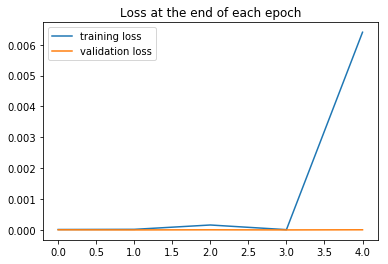

In [42]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [41]:
test_losses

[tensor(3.8266e-06),
 tensor(2.8610e-07),
 tensor(3.6835e-06),
 tensor(1.6689e-07),
 tensor(4.4106e-06)]

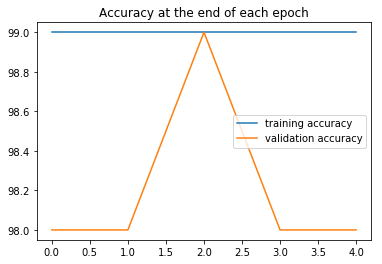

In [43]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [44]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [45]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [46]:
correct.item()/len(test_data)

0.9886

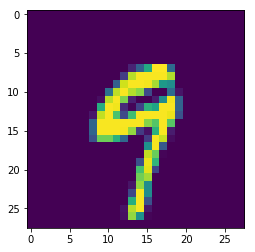

In [50]:
plt.imshow(test_data[2019][0].reshape(28,28))

In [51]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1,1,28,28))

In [52]:
new_prediction.argmax()

tensor(9)

CIFAR-10 Dataset with CNN

- 32x32 color images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.CIFAR10(root=../Data)